# Assignment 2. Data Extraction and Statistical Hypothesis Testing

*Foundations of Data Science*  
*Dr. Khalaj (Fall 2025)*  

<!-- *For your questions refer to mehrshadtaji61@gmail.com or @m522t on Telegram* -->
In this exercise, you will collect real-world data from **TripAdvisor (tripadvisor.com)** to build a dataset of restaurants located in **New York City**.  
Your goal is to extract restaurant information from **six neighborhoods** and store the results in a structured **database** for later analysis.


### Information  
Complete the information box below.

full_name = "Tina Halimi"    
student_id = "400101078"


### Neighborhoods to Focus On

You will collect data from the following **six neighborhoods**:

1. **Downtown Manhattan (Downtown)**
2. **Midtown West**
3. **Midtown**
4. **Upper Manhattan (Uptown)**
5. **Upper East Side**
6. **Greenwich Village**

For each neighborhood, aim to extract data for approximately **100 restaurants**.

---

### Requirements and Setup

Your script **must** use `undetected_chromedriver` with **Selenium** to simulate human-like browsing and avoid being blocked by TripAdvisor’s protection system.

For each restaurant, extract the following fields:

| Field | Description |
|--------|--------------|
| **Name** | Restaurant name |
| **Neighborhood** | The area the restaurant belongs to |
| **Rating** | Average user rating |
| **Number of Reviews** | Total number of customer reviews |
| **Cuisine Type** | Main type(s) of food served (e.g., Italian, Japanese) |
| **Price Range** | Price level represented by `$`, `$$`, `$$$`, or `$$$$` |





### Anti-Blocking Guidelines

To minimize blocking or CAPTCHA issues, follow these guidelines:

- Always use **`undetected_chromedriver`** instead of the standard Chrome driver.  
- Add **random sleep intervals (2–5 seconds)** between actions.  
- **Scroll down** each page to ensure all restaurants are fully loaded.  
- If a **CAPTCHA** appears, **pause execution** and solve it manually.  
- Avoid sending requests or clicking too frequently.  
- Simulate realistic, human-like browsing behavior.

---

### Data Collecting


In [ ]:
!pip install selenium

In [ ]:
!pip install undetected-chromedriver

In [ ]:
!pip install webdriver-manager


In [ ]:
# ===============================
# Data Collecting – Step 1
# Human-like TripAdvisor browser
# ===============================

import time
import random
import csv
from pathlib import Path
from selenium.common.exceptions import TimeoutException
import json
import undetected_chromedriver as uc
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

driver_executable_path = './chromedriver'

# ---------- Human-like utilities ----------

def human_sleep(min_s: float = 2.0, max_s: float = 5.0):
    """Sleep a random time between actions to look less like a bot."""
    t = random.uniform(min_s, max_s)
    time.sleep(t)


def human_scroll(driver, min_step: int = 300, max_step: int = 800):
    """
    Scroll down the page in several small, random steps,
    with small pauses between them.
    """
    total_height = driver.execute_script("return document.body.scrollHeight")
    current = 0

    while current < total_height:
        step = random.randint(min_step, max_step)
        current += step
        driver.execute_script(f"window.scrollTo(0, {current});")
        human_sleep(0.5, 1.5)


# ---------- Driver setup ----------
def create_driver():
    options = uc.ChromeOptions()
    options.add_argument("--start-maximized")
    options.add_argument("--disable-blink-features=AutomationControlled")

    # path to Chrome on macOS (adjust only if you installed it somewhere unusual)
    chrome_path = "/Applications/Google Chrome.app/Contents/MacOS/Google Chrome"
    if not Path(chrome_path).exists():
        raise FileNotFoundError(f"Chrome not found at {chrome_path}")

    options.binary_location = chrome_path

    driver = uc.Chrome(options=options)
    return driver


# ---------- Core scraping skeleton ----------
NEIGHBORHOODS = {
    "Downtown":      "https://www.tripadvisor.com/FindRestaurants?geo=60763&establishmentTypes=10591&neighborhoods=15565677&broadened=false",
    "Midtown West":  "https://www.tripadvisor.com/FindRestaurants?geo=60763&establishmentTypes=10591&neighborhoods=15565657&broadened=false",
    "Midtown":       "https://www.tripadvisor.com/FindRestaurants?geo=60763&establishmentTypes=10591&neighborhoods=7102352&broadened=false",
    "Uptown":        "https://www.tripadvisor.com/FindRestaurants?geo=60763&establishmentTypes=10591&neighborhoods=15565675&broadened=false",
    "Upper East Side": "https://www.tripadvisor.com/FindRestaurants?geo=60763&establishmentTypes=10591&neighborhoods=7102356&broadened=false",
    "Greenwich Village": "https://www.tripadvisor.com/FindRestaurants?geo=60763&establishmentTypes=10591&neighborhoods=7102348&broadened=false",
}

OUTPUT_PATH = Path("nyc_restaurants_tripadvisor.csv")




def extract_restaurants_from_list_page(driver, neighborhood):
    """
    Extract restaurant info from ONE list page using JSON-LD for most fields
    and HTML as a fallback for cuisine_type when needed.
    """
    restaurants_data = []

    # ---------- JSON-LD part (name, rating, reviews, price, cuisine if available) ----------
    try:
        script_elem = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located(
                (
                    By.CSS_SELECTOR,
                    "div[data-automation='restaurant-list-jsonld'] > script[type='application/ld+json']"
                )
            )
        )
    except TimeoutException:
        print("⚠️ JSON-LD script not found on this page.")
        return restaurants_data

    json_text = script_elem.get_attribute("innerHTML") or script_elem.get_attribute("textContent")
    if not json_text:
        print("⚠️ JSON-LD script was empty.")
        return restaurants_data

    try:
        data = json.loads(json_text)
    except json.JSONDecodeError as e:
        print(f"⚠️ Failed to parse JSON-LD: {e}")
        return restaurants_data

    if isinstance(data, dict) and "itemListElement" in data:
        items = data["itemListElement"]
    elif isinstance(data, list):
        items = data
    else:
        items = []

    # parse JSON into list of dicts
    for el in items:
        if isinstance(el, dict) and "item" in el:
            item = el["item"]
        else:
            item = el

        if not isinstance(item, dict):
            continue

        name = item.get("name")

        agg = item.get("aggregateRating") or {}
        rating_val = agg.get("ratingValue")
        review_count = agg.get("reviewCount")

        # ------- cuisine from JSON-LD (robust parsing) -------
        cuisines_raw = item.get("servesCuisine")
        cuisine_type = None
        if cuisines_raw is not None:
            if isinstance(cuisines_raw, list):
                parts = []
                for c in cuisines_raw:
                    if isinstance(c, str):
                        parts.append(c)
                    elif isinstance(c, dict) and "name" in c:
                        parts.append(str(c["name"]))
                    else:
                        parts.append(str(c))
                if parts:
                    cuisine_type = ", ".join(parts)
            elif isinstance(cuisines_raw, dict) and "name" in cuisines_raw:
                cuisine_type = str(cuisines_raw["name"])
            else:
                cuisine_type = str(cuisines_raw)

        price_range = item.get("priceRange")

        restaurants_data.append(
            {
                "name": name,
                "neighborhood": neighborhood,
                "rating": float(rating_val) if rating_val is not None else None,
                "n_reviews": int(review_count) if review_count is not None else None,
                "cuisine_type": cuisine_type,   # may still be None, we’ll fix next
                "price_range": price_range,
            }
        )

    # ---------- Fallback: fill missing cuisine_type from HTML cards ----------
    try:
        cards = driver.find_elements(By.CSS_SELECTOR, "div[data-automation='restaurantCard']")
    except Exception:
        cards = []

    for i, row in enumerate(restaurants_data):
        if row["cuisine_type"] or i >= len(cards):
            continue  

        card = cards[i]
        try:
            # In the card, cuisines are usually a span under the ZvrsvW wrapper
            cuisine_elem = card.find_element(
                By.XPATH,
                ".//div[contains(@class,'Zvr') or contains(@class,'ZvrsvW')]" 
                "//span[contains(text(), ',') or contains(text(), '•')]"
            )
            row["cuisine_type"] = cuisine_elem.text.strip()
        except Exception:
            pass

    print(f"{neighborhood}: parsed {len(restaurants_data)} restaurants (cuisine filled where possible).")
    return restaurants_data


def go_to_next_page(driver):
    """
    Click the 'next page' button if it exists. Returns True if moved, False otherwise.
    """
    try:
        next_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, "a[aria-label='Next page']")
            )
        )
        human_sleep()        
        next_button.click()
        human_sleep(3, 6)  
        return True
    except Exception:
        return False


def collect_for_neighborhood(driver, neighborhood, url, target_n=100):
    """
    Browse through pages for one neighborhood, simulating human behavior,
    until ~target_n restaurants are collected or pages end.
    """
    all_rows = []
    driver.get(url)

    # initial pause and scroll so page fully loads
    human_sleep(4, 7)
    human_scroll(driver)

    while len(all_rows) < target_n:
        # Extract data from current page
        page_rows = extract_restaurants_from_list_page(driver, neighborhood)
        all_rows.extend(page_rows)

        print(f"{neighborhood}: collected {len(all_rows)} restaurants so far")

        if len(all_rows) >= target_n:
            break

        # Scroll back to top before moving page (mimics a real user)
        driver.execute_script("window.scrollTo(0, 0);")
        human_sleep()

        # Try to go to next page; if not possible, stop
        moved = go_to_next_page(driver)
        if not moved:
            print(f"No more pages for {neighborhood}.")
            break

        # Scroll again on the new page
        human_scroll(driver)

    return all_rows[:target_n]


def main():
    driver = create_driver()
    all_data = []

    try:
        for neighborhood, url in NEIGHBORHOODS.items():
            print(f"\n=== Scraping {neighborhood} ===")
            rows = collect_for_neighborhood(driver, neighborhood, url, target_n=100)
            all_data.extend(rows)

        # Save to CSV
        fieldnames = ["name", "neighborhood", "rating", "n_reviews", "cuisine_type", "price_range"]
        with OUTPUT_PATH.open("w", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(all_data)

        print(f"\nSaved {len(all_data)} rows to {OUTPUT_PATH}")
    finally:
        driver.quit()


if __name__ == "__main__":
    main()



=== Scraping Downtown ===
Downtown: parsed 30 restaurants (cuisine filled where possible).
Downtown: collected 30 restaurants so far
Downtown: parsed 30 restaurants (cuisine filled where possible).
Downtown: collected 60 restaurants so far
Downtown: parsed 30 restaurants (cuisine filled where possible).
Downtown: collected 90 restaurants so far
Downtown: parsed 30 restaurants (cuisine filled where possible).
Downtown: collected 120 restaurants so far

=== Scraping Midtown West ===
Midtown West: parsed 30 restaurants (cuisine filled where possible).
Midtown West: collected 30 restaurants so far
Midtown West: parsed 30 restaurants (cuisine filled where possible).
Midtown West: collected 60 restaurants so far
Midtown West: parsed 30 restaurants (cuisine filled where possible).
Midtown West: collected 90 restaurants so far
Midtown West: parsed 30 restaurants (cuisine filled where possible).
Midtown West: collected 120 restaurants so far

=== Scraping Midtown ===
Midtown: parsed 30 restaur

###  Data Storage

After collecting the data, store it in a **database** (not a flat file).  
You may use **SQLite** (recommended) or **MySQL/PostgreSQL**.



In [ ]:
pip install statsmodels

In [67]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, f_oneway
import statsmodels.formula.api as smf

In [ ]:
CSV_PATH = Path("nyc_restaurants_tripadvisor.csv")
DB_PATH  = Path("restaurants.db")

# 1) Load CSV
df = pd.read_csv(CSV_PATH)
print(f"Loaded {len(df)} rows from CSV")

# 2) Clean types + NaNs
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
df["n_reviews"] = pd.to_numeric(df["n_reviews"], errors="coerce")

df = df.where(pd.notnull(df), None)

# enforce column order
df = df[["name", "neighborhood", "rating", "n_reviews", "cuisine_type", "price_range"]]

# 3) Connect + create table
conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()

cur.execute("""
CREATE TABLE IF NOT EXISTS restaurants (
    id           INTEGER PRIMARY KEY AUTOINCREMENT,
    name         TEXT,
    neighborhood TEXT,
    rating       REAL,
    n_reviews    INTEGER,
    cuisine_type TEXT,
    price_range  TEXT
)
""")

cur.execute("DELETE FROM restaurants")

# 4) Insert
rows = list(df.itertuples(index=False, name=None))

cur.executemany("""
INSERT INTO restaurants
(name, neighborhood, rating, n_reviews, cuisine_type, price_range)
VALUES (?, ?, ?, ?, ?, ?)
""", rows)

conn.commit()
print("Saved data into SQLite database:", DB_PATH)

# 5) Sanity check
print("\nSample rows from the database:")
for row in cur.execute("""
    SELECT name, neighborhood, rating, n_reviews, cuisine_type, price_range
    FROM restaurants
    LIMIT 5;
"""):
    print(row)

conn.close()


Loaded 600 rows from CSV
Saved data into SQLite database: restaurants.db

Sample rows from the database:
('Boucherie West Village', 'Downtown', 4.8, 2331, 'French, American', '$$ - $$$')
('Piccola Cucina Osteria', 'Downtown', 4.7, 3498, 'Steakhouse, Seafood', '$$ - $$$')
('Piccola Cucina Estiatorio', 'Downtown', 4.8, 1158, None, '$$ - $$$')
('Olio E Più', 'Downtown', 4.7, 3855, 'Italian, Sicilian', '$$ - $$$')
('Numero 28 Pizzeria', 'Downtown', 4.7, 1920, 'Italian, Sicilian', '$$ - $$$')


---

Using the data you collected, answer the following questions:

- How is the **distribution of restaurant prices** across different neighborhoods?  
- What are the **most common cuisine types** among restaurants?  
- Do **Italian restaurants** show significant differences in their **average price levels** across neighborhoods in New York City?

---


### Q1

In [62]:
# ======================================
# Q1 – Price distribution across neighborhoods
# ======================================

# 1) Load neighborhood + price_range from SQLite
conn = sqlite3.connect("restaurants.db")
df = pd.read_sql_query("""
    SELECT neighborhood, price_range
    FROM restaurants
""", conn)
conn.close()

# 2) Count restaurants per (neighborhood, price_range)  -> wide table
price_dist = (
    df.groupby(["neighborhood", "price_range"])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

print("Counts of price ranges per neighborhood:\n")
print(price_dist)

# 3) Percentage distribution within each neighborhood
price_dist_pct = price_dist.div(price_dist.sum(axis=1), axis=0) * 100
print("\nPercent of restaurants in each price range (per neighborhood):\n")
print(price_dist_pct.round(1))

Counts of price ranges per neighborhood:

price_range         $  $$ - $$$  $$$$
neighborhood                         
Downtown            7        78    15
Greenwich Village   8        75    17
Midtown            10        59    31
Midtown West        7        69    24
Upper East Side     4        73    23
Uptown             20        78     1

Percent of restaurants in each price range (per neighborhood):

price_range           $  $$ - $$$  $$$$
neighborhood                           
Downtown            7.0      78.0  15.0
Greenwich Village   8.0      75.0  17.0
Midtown            10.0      59.0  31.0
Midtown West        7.0      69.0  24.0
Upper East Side     4.0      73.0  23.0
Uptown             20.2      78.8   1.0


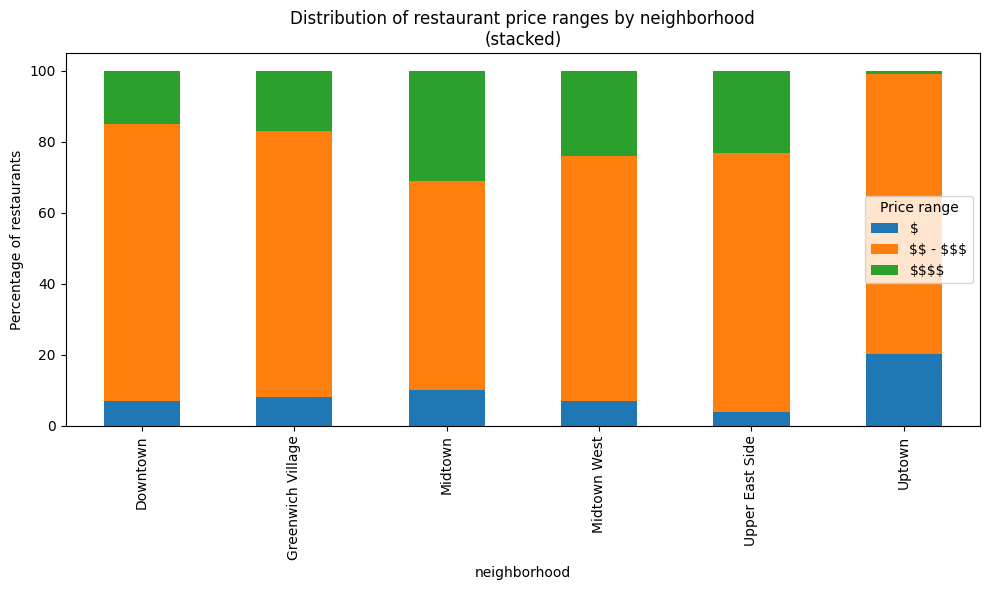

In [63]:
# --------------------------------------
# Plot A: stacked bar chart
# --------------------------------------
safe_cols = [
    c.replace("$", r"\$") if isinstance(c, str) else c
    for c in price_dist_pct.columns
]
price_dist_pct_plot = price_dist_pct.copy()
price_dist_pct_plot.columns = safe_cols

ax = price_dist_pct_plot.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6)
)
ax.set_ylabel("Percentage of restaurants")
ax.set_title("Distribution of restaurant price ranges by neighborhood\n(stacked)")
plt.legend(title="Price range")
plt.tight_layout()
plt.show()

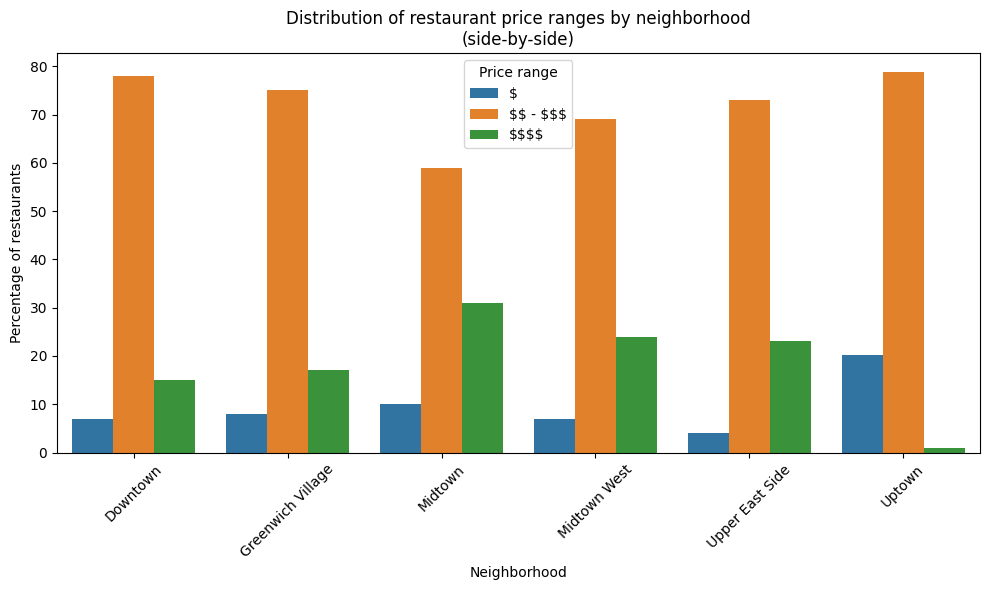

In [ ]:
# --------------------------------------
# Plot B: side-by-side bar chart
# --------------------------------------
price_counts = (
    price_dist
    .stack()
    .reset_index(name="count")  
)

total_per_nbhd = price_counts.groupby("neighborhood")["count"].transform("sum")
price_counts["percent"] = 100 * price_counts["count"] / total_per_nbhd

nbhd_order = ["Downtown", "Greenwich Village", "Midtown",
              "Midtown West", "Upper East Side", "Uptown"]
price_order = ["$", "$$ - $$$", "$$$$"]

price_counts["neighborhood"] = pd.Categorical(
    price_counts["neighborhood"], nbhd_order, ordered=True
)
price_counts["price_range"] = pd.Categorical(
    price_counts["price_range"], price_order, ordered=True
)

price_counts["price_range_safe"] = price_counts["price_range"].astype(str).str.replace(
    "$", r"\$", regex=False
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=price_counts,
    x="neighborhood",
    y="percent",
    hue="price_range_safe",
)

plt.title("Distribution of restaurant price ranges by neighborhood\n(side-by-side)")
plt.ylabel("Percentage of restaurants")
plt.xlabel("Neighborhood")
plt.xticks(rotation=45)
plt.legend(title="Price range")
plt.tight_layout()
plt.show()

### Q2

In [65]:
# ======================================
# Q2: Most common cuisine types
# ======================================

# 1) Load cuisine_type column from SQLite
conn = sqlite3.connect("restaurants.db")
df = pd.read_sql_query("""
    SELECT cuisine_type
    FROM restaurants
""", conn)
conn.close()

# 2) Drop missing values (some restaurants may not have cuisine info)
df = df.dropna(subset=['cuisine_type'])

# 3) Split comma-separated cuisines and explode into rows
df['cuisine_type'] = df['cuisine_type'].str.split(',')
df = df.explode('cuisine_type')

# 4) Clean whitespace: " Italian " → "Italian"
df['cuisine_type'] = df['cuisine_type'].str.strip()

# 5) Count cuisines
counts = (
    df['cuisine_type']
      .value_counts()
      .sort_values(ascending=False)
)

print("Top cuisine types:\n")
print(counts.head(20))


Top cuisine types:

cuisine_type
American         156
Italian           99
Seafood           90
Steakhouse        84
French            61
Bar               57
Pizza             52
Japanese          35
Latin             29
Contemporary      25
Mediterranean     24
Mexican           24
Asian             24
European          20
Sushi             20
Cafe              13
Healthy           10
Diner             10
Chinese            8
Caribbean          8
Name: count, dtype: int64


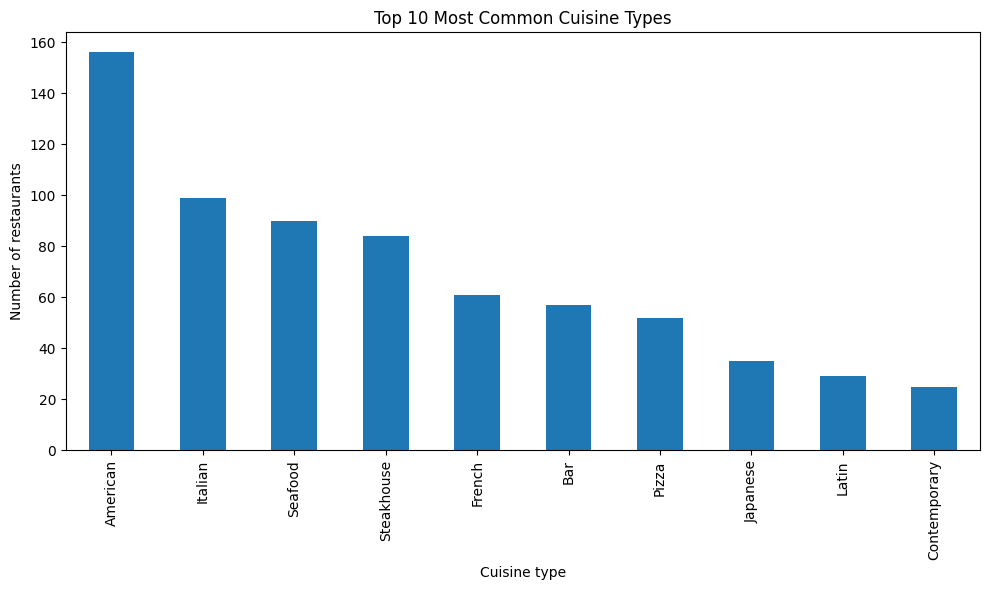

In [66]:
# 6) Plot top 10 cuisines
plt.figure(figsize=(10, 6))
counts.head(10).plot(kind='bar')
plt.title("Top 10 Most Common Cuisine Types")
plt.ylabel("Number of restaurants")
plt.xlabel("Cuisine type")
plt.tight_layout()
plt.show()

### Q3

In [ ]:
# =====================================================
# Q3: Do Italian restaurants differ in average price level across neighborhoods?
# =====================================================

# 1) Load data from SQLite
conn = sqlite3.connect("restaurants.db")
df = pd.read_sql_query("""
    SELECT neighborhood, cuisine_type, price_range
    FROM restaurants
""", conn)
conn.close()

# 2) Keep only Italian restaurants
italian = df[df["cuisine_type"].str.contains("Italian", na=False)]

print(f"Number of Italian restaurants: {len(italian)}")

# 3) Convert price_range → numeric values
price_map = {
    "$": 1,
    "$$": 2,
    "$$ - $$$": 2.5,
    "$$$": 3,
    "$$$ - $$$$": 3.5,
    "$$$$": 4,
}

italian["price_num"] = italian["price_range"].map(price_map)

# 4) Group by neighborhood
groups = [
    group["price_num"].dropna()
    for nbhd, group in italian.groupby("neighborhood")
    if len(group["price_num"].dropna()) > 1   
]

labels = [
    nbhd
    for nbhd, group in italian.groupby("neighborhood")
    if len(group["price_num"].dropna()) > 1
]

print("\nNeighborhoods included in ANOVA:", labels)

# 5) Run ANOVA if we have at least 2 neighborhoods with data
if len(groups) >= 2:
    F, p = f_oneway(*groups)
    print(f"\nANOVA results:")
    print(f"F-statistic = {F:.3f}")
    print(f"p-value     = {p:.4f}")

    # 6) Interpretation
    alpha = 0.05
    print("\nInterpretation:")
    if p < alpha:
        print("✔ The p-value is < 0.05, so we REJECT the null hypothesis.")
        print("  → Italian restaurants differ significantly in average price level across neighborhoods.")
    else:
        print("✘ The p-value is > 0.05, so we FAIL TO REJECT the null hypothesis.")
        print("  → No significant evidence that Italian restaurant prices differ by neighborhood.")
else:
    print("Not enough data to run ANOVA (need >= 2 neighborhoods with Italian restaurants).")


Number of Italian restaurants: 99

Neighborhoods included in ANOVA: ['Downtown', 'Greenwich Village', 'Midtown', 'Midtown West', 'Upper East Side', 'Uptown']

ANOVA results:
F-statistic = 2.004
p-value     = 0.0853

Interpretation:
✘ The p-value is > 0.05, so we FAIL TO REJECT the null hypothesis.
  → No significant evidence that Italian restaurant prices differ by neighborhood.


/var/folders/tg/b1z1k0cx1z1cr_jv24vhxgrm0000gn/T/ipykernel_14758/3839599723.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  italian["price_num"] = italian["price_range"].map(price_map)


### Q4

First, explore the **distribution of restaurant prices** across different neighborhoods.  
- What patterns do you observe?  
- Are expensive restaurants concentrated in specific areas, or are they spread evenly across the city?  

Then, test the following **claim**:  

> *“Expensive restaurants ($$$–$$$$) have higher average ratings than cheaper ones ($–$$).”*  


#### Notes: I have already shown the distribution on restaurant prices across different neighborhoods in Q1. In this part I will use that and I will implement the hypothesis testing.

In [ ]:
# =====================================================
# Do expensive restaurants have higher ratings?
# =====================================================

df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

# Define price groups
cheap_prices = ["$", "$$"]
expensive_prices = ["$$$", "$$$ - $$$$", "$$$$"]

# Create two subsets
cheap = df[df["price_range"].isin(cheap_prices)]["rating"].dropna()
expensive = df[df["price_range"].isin(expensive_prices)]["rating"].dropna()

print(f"Cheap restaurants count: {len(cheap)}")
print(f"Expensive restaurants count: {len(expensive)}")

# Compare averages
print("\nAverage rating (cheap):", cheap.mean())
print("Average rating (expensive):", expensive.mean())

# Two-sample t-test (independent groups)
t_stat, p_value = ttest_ind(expensive, cheap, equal_var=False)

print("\nTwo-sample t-test:")
print("t-statistic =", t_stat)
print("p-value     =", p_value)

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("\n✔ RESULT: Significant difference (p < 0.05).")
    print("  → Expensive restaurants have a statistically different (likely higher) average rating.")
else:
    print("\n✘ RESULT: No significant difference (p ≥ 0.05).")
    print("  → We cannot conclude that expensive restaurants have higher ratings.")


Cheap restaurants count: 56
Expensive restaurants count: 111

Average rating (cheap): 4.360714285714286
Average rating (expensive): 4.42072072072072

Two-sample t-test:
t-statistic = 1.6194473208018396
p-value     = 0.10872057459422083

✘ RESULT: No significant difference (p ≥ 0.05).
  → We cannot conclude that expensive restaurants have higher ratings.


#### **Interpretation of Results**

An analysis of restaurant price distributions across New York City neighborhoods shows that mid-priced restaurants (`$$ – $$$`) dominate the dining landscape in every area, consistently accounting for the majority of available options. While affordable restaurants (`$`) are present in all neighborhoods, they are notably more common in Uptown, where they make up about 20% of establishments—far higher than in other districts. In contrast, upscale restaurants (`$$$–$$$$`) are unevenly distributed: they are heavily concentrated in central and affluent areas such as Midtown, Midtown West, the Upper East Side, and Downtown, while they are almost absent in Uptown. This suggests that high-end dining tends to cluster in business and high-income neighborhoods rather than being evenly spread across the city.

To test whether expensive restaurants receive higher ratings, a two-sample t-test was conducted comparing cheaper restaurants (`$–$$`) with more expensive ones (`$$$–$$$$`). Although expensive restaurants had a slightly higher average rating (4.42 vs. 4.36), the difference was not statistically significant (p = 0.1087). Therefore, there is no evidence to support the claim that costly restaurants are rated higher; any observed difference is likely due to random variation rather than a meaningful relationship between price and customer satisfaction.
____

### Q5

Now focus on restaurant ratings in two different neighborhoods (for example, Downtown Manhattan vs. Upper Manhattan).

Test the following hypothesis:

- H₀: The average rating of restaurants in both neighborhoods is equal.
- H₁: Restaurants in Downtown Manhattan have higher average ratings than those in Upper Manhattan.

In [ ]:
# =====================================================
# Hypothesis Test: Downtown vs Uptown Ratings
# H0: mean_Downtown = mean_Uptown
# H1: mean_Downtown > mean_Uptown (one-tailed)
# =====================================================

# 1) Load ratings + neighborhood from DB
conn = sqlite3.connect("restaurants.db")
df = pd.read_sql_query("""
    SELECT neighborhood, rating
    FROM restaurants
""", conn)
conn.close()

df["rating"] = pd.to_numeric(df["rating"], errors="coerce")

# 2) Extract the two neighborhoods
downtown = df[df["neighborhood"].str.contains("Downtown", case=False, na=False)]["rating"].dropna()
uptown   = df[df["neighborhood"].str.contains("Uptown",   case=False, na=False)]["rating"].dropna()

print(f"Downtown count: {len(downtown)}")
print(f"Uptown count: {len(uptown)}")

print("\nAverage rating (Downtown):", downtown.mean())
print("Average rating (Uptown):", uptown.mean())

# 3) Two-sample t-test (two-tailed first)
t_stat, p_two_tailed = ttest_ind(downtown, uptown, equal_var=False)

# 4) Convert to one-tailed p-value (H1: Downtown > Uptown)
if t_stat > 0:
    p_one_tailed = p_two_tailed / 2
else:
    p_one_tailed = 1 - (p_two_tailed / 2)

print("\nTwo-sample t-test (Welch's):")
print("t-statistic =", t_stat)
print("Two-tailed p-value =", p_two_tailed)
print("One-tailed p-value (Downtown > Uptown) =", p_one_tailed)

# 5) Interpretation
alpha = 0.05
print("\nInterpretation:")
if p_one_tailed < alpha:
    print("✔ Reject H₀: Downtown restaurants have significantly higher ratings.")
else:
    print("✘ Fail to reject H₀: No significant evidence that Downtown restaurants are rated higher.")


Downtown count: 100
Uptown count: 100

Average rating (Downtown): 4.417999999999999
Average rating (Uptown): 4.294999999999999

Two-sample t-test (Welch's):
t-statistic = 4.085103465997803
Two-tailed p-value = 6.800949354964146e-05
One-tailed p-value (Downtown > Uptown) = 3.400474677482073e-05

Interpretation:
✔ Reject H₀: Downtown restaurants have significantly higher ratings.


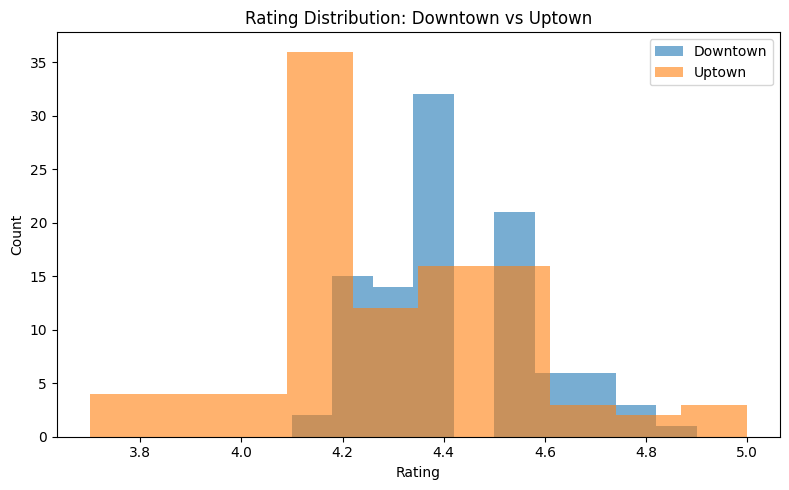

In [ ]:
# Visualization

df = pd.read_csv("nyc_restaurants_tripadvisor.csv")

downtown = df[df["neighborhood"] == "Downtown"]["rating"]
uptown = df[df["neighborhood"] == "Uptown"]["rating"]

plt.figure(figsize=(8,5))
plt.hist(downtown, bins=10, alpha=0.6, label="Downtown")
plt.hist(uptown, bins=10, alpha=0.6, label="Uptown")

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating Distribution: Downtown vs Uptown")
plt.legend()
plt.tight_layout()
plt.show()


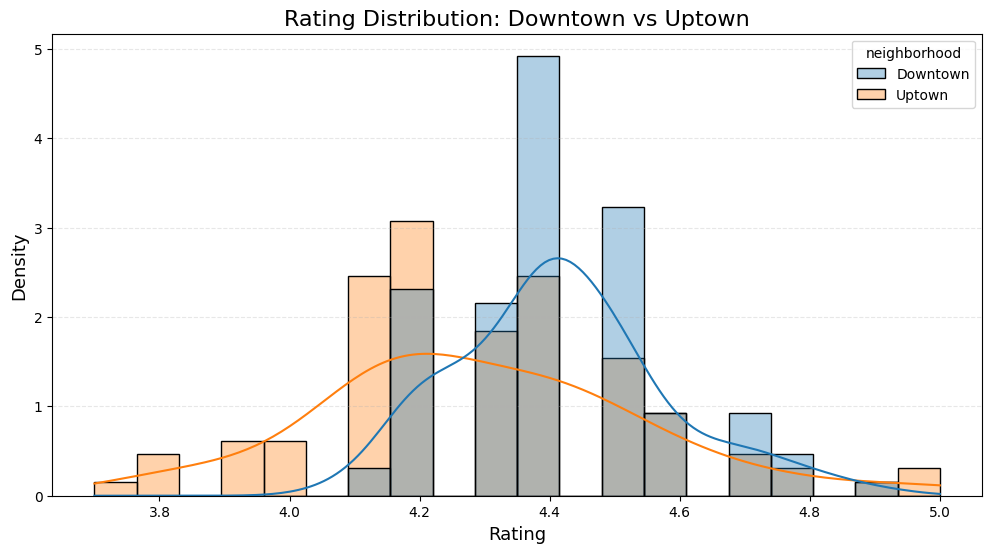

In [ ]:
# more detailed plot
conn = sqlite3.connect("restaurants.db")
df = pd.read_sql_query("""
    SELECT neighborhood, rating
    FROM restaurants
""", conn)
conn.close()

target_neighborhoods = ["Downtown", "Uptown"]
df_sub = df[df["neighborhood"].isin(target_neighborhoods)]

plt.figure(figsize=(12, 6))

# Histogram + KDE
sns.histplot(
    data=df_sub,
    x="rating",
    hue="neighborhood",
    bins=20,
    kde=True,
    stat="density",
    common_norm=False,
    alpha=0.35
)

plt.title("Rating Distribution: Downtown vs Uptown", fontsize=16)
plt.xlabel("Rating", fontsize=13)
plt.ylabel("Density", fontsize=13)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()


#### **Interpretation of Results**

The statistical comparison between Downtown and Uptown restaurants shows a meaningful difference in their rating patterns. Downtown restaurants have a slightly higher average rating (4.42) compared to Uptown restaurants (4.29). The Welch two-sample t-test confirms that this difference is statistically significant: the one-tailed p-value is extremely small (≈ 3.4×10⁻⁵), well below the 0.05 threshold. This allows us to **reject the null hypothesis** and conclude that Downtown restaurants tend to score higher than those in Uptown. The histogram supports this result visually—Downtown ratings cluster more tightly around the mid-to-high 4.4 range, while Uptown ratings show more spread and more values on the lower end. Together, these results provide strong evidence that Downtown restaurants receive better customer ratings on average.

---


### Q6

In this section, we want to explore whether restaurants with higher ratings also have more visitors.
Our dataset does not directly contain the number of visitors, but according to studies on restaurant review platforms, only about 7% of customers actually leave a review.


Create a scatter plot between rating and log(reviews + 1).

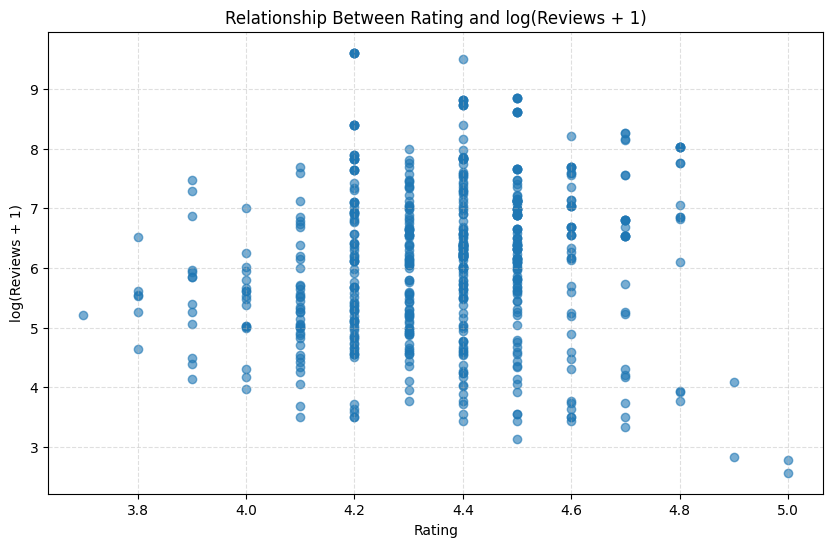

In [ ]:
conn = sqlite3.connect("restaurants.db")
df = pd.read_sql_query("SELECT name, rating, n_reviews FROM restaurants", conn)
conn.close()

# Compute log(reviews + 1)
df["log_reviews"] = np.log(df["n_reviews"] + 1)

plt.figure(figsize=(10, 6))
plt.scatter(df["rating"], df["log_reviews"], alpha=0.6)

plt.title("Relationship Between Rating and log(Reviews + 1)")
plt.xlabel("Rating")
plt.ylabel("log(Reviews + 1)")

plt.grid(True, linestyle="--", alpha=0.4)
plt.show()


#### **Interpretation of Results**

The scatter plot shows the relationship between restaurant ratings and the log of the number of reviews (a proxy for estimated visitor count). Overall, the points are widely dispersed, indicating **no strong linear relationship** between rating and popularity. Restaurants with ratings between **4.2 and 4.6** appear across the entire range of review counts—from very few to several thousand—suggesting that higher ratings do not necessarily correspond to more visitors. However, we do observe a subtle pattern: **restaurants with extremely high review counts tend to have mid-to-high ratings**, typically around 4.2–4.6, while very low-review restaurants show more rating variability. This implies that popularity stabilizes ratings toward the middle range, but it does **not** indicate that higher ratings cause more visitors. Rather, popular restaurants simply accumulate more ratings over time.

---


### Q7

Calculate the correlation coefficient between these two variables.

Do restaurants with higher ratings usually have more reviews?
Does this relationship appear linear?

In [ ]:
df["log_reviews"] = np.log(df["n_reviews"] + 1)

# Correlation coefficient
corr = df["rating"].corr(df["log_reviews"])

print("Correlation between rating and log(reviews+1):", corr)


Correlation between rating and log(reviews+1): 0.10963900464903271


#### **Interpretation of Results**
### **Do restaurants with higher ratings usually have more reviews?**

Based on the correlation coefficient (**r ≈ 0.11**), the relationship between restaurant rating and the number of reviews is **very weak and only slightly positive**.
This means:

* Restaurants with higher ratings **do not necessarily** have more reviews.
* There is only a *small tendency* for higher-rated restaurants to have more visitors (as approximated by review counts), but it is far from strong or consistent.

In practice, this suggests that **popularity (many reviews)** and **quality (high rating)** are almost independent in this dataset.

---

### **Does this relationship appear linear?**

**No.**
The scatter plot shows a **cloud of points with no strong upward trend**. The points are widely spread, and ratings are tightly clustered between 4.0 and 4.7 while review counts vary dramatically.

The pattern suggests:

* Review counts vary for many different reasons (location, age of restaurant, hype, tourist traffic, etc.).
* Ratings show very little variation, making a linear trend difficult to detect.
* The relationship is **nonlinear or possibly nonexistent** rather than linear.

---

### Q8

Could neighborhood be a factor influencing  the number of reviews?

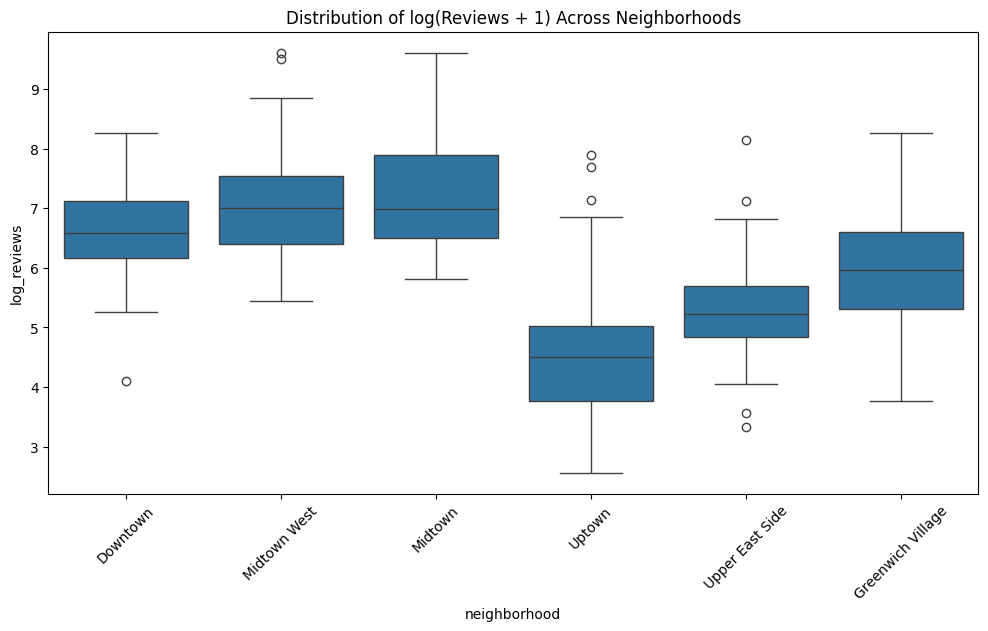

In [ ]:

conn = sqlite3.connect("restaurants.db")
df = pd.read_sql_query("SELECT * FROM restaurants", conn)
conn.close()

# Use log(reviews+1) since review counts are very skewed
df["log_reviews"] = np.log(df["n_reviews"] + 1)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="neighborhood", y="log_reviews")
plt.title("Distribution of log(Reviews + 1) Across Neighborhoods")
plt.xticks(rotation=45)
plt.show()


In [ ]:
groups = [g["log_reviews"].values for name, g in df.groupby("neighborhood")]

f_stat, p_value = stats.f_oneway(*groups)

print("ANOVA results:")
print("F-statistic:", f_stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("\n✔ RESULT: Reject H0 — Neighborhood *does* significantly influence review counts.")
else:
    print("\n✘ RESULT: Fail to reject H0 — No evidence that neighborhoods differ in review counts.")


ANOVA results:
F-statistic: 147.82451493873148
p-value: 8.58853134393185e-102

✔ RESULT: Reject H0 — Neighborhood *does* significantly influence review counts.


#### **Interpretation of Results**

The analysis shows that **neighborhood plays a major role in how many reviews a restaurant receives**. The boxplot reveals large differences across areas: restaurants in **Midtown** and **Midtown West** tend to have the highest review counts, followed closely by **Downtown**, reflecting their dense commercial activity and heavy foot traffic. In contrast, **Uptown** restaurants consistently receive fewer reviews, suggesting lower visitor volume or less tourist exposure. The ANOVA test confirms these visual patterns statistically, with an extremely small p-value (≈ 8.6 × 10⁻¹⁰²), providing strong evidence that review counts differ significantly among neighborhoods. Overall, the results indicate that **restaurants located in busier, more central neighborhoods attract substantially more customer engagement** than those in more residential or less trafficked areas.

---

### Q9

Now analyze the relationship between rating, number of visits (approximated by reviews), and neighborhood.


Correlation between rating and log(reviews) BY neighborhood:

neighborhood             
Downtown           rating   -0.170607
Greenwich Village  rating   -0.230613
Midtown            rating   -0.366867
Midtown West       rating    0.000954
Upper East Side    rating   -0.120707
Uptown             rating   -0.412126
Name: log_reviews, dtype: float64


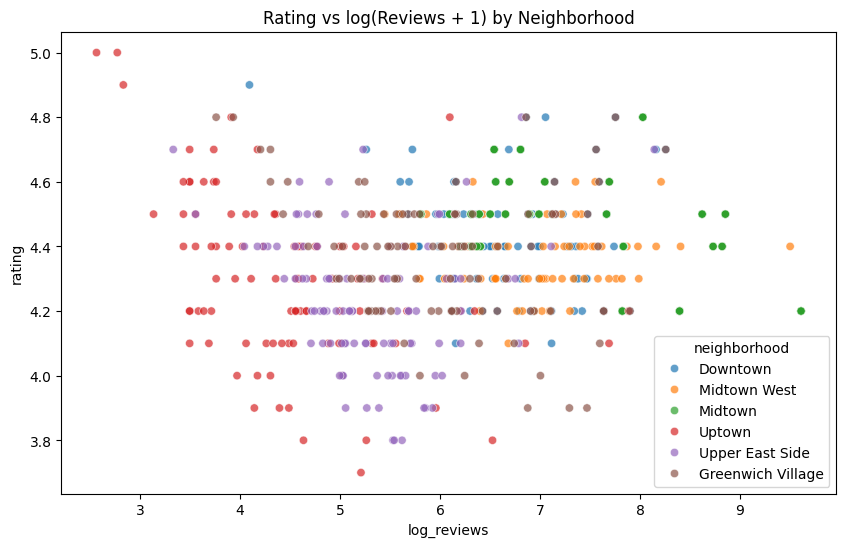


Regression Results: rating ~ log_reviews + neighborhood

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     25.88
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           2.18e-27
Time:                        23:36:19   Log-Likelihood:                 171.34
No. Observations:                 600   AIC:                            -328.7
Df Residuals:                     593   BIC:                            -297.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

In [ ]:
df = pd.read_sql_query("SELECT * FROM restaurants", sqlite3.connect("restaurants.db"))

df["log_reviews"] = np.log(df["n_reviews"] + 1)

# ---------------------------------------------------
# 1. Correlation between rating and log_reviews by neighborhood
# ---------------------------------------------------
corrs = df.groupby("neighborhood")[["rating", "log_reviews"]].corr().iloc[0::2, -1]
print("\nCorrelation between rating and log(reviews) BY neighborhood:\n")
print(corrs)

# ---------------------------------------------------
# 2. Visualization: rating vs log_reviews by neighborhood
# ---------------------------------------------------
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="log_reviews", y="rating", hue="neighborhood", alpha=0.7)
plt.title("Rating vs log(Reviews + 1) by Neighborhood")
plt.show()

# ---------------------------------------------------
# 3. Regression model: does neighborhood still matter?
# rating ~ log_reviews + neighborhood
# ---------------------------------------------------
model = smf.ols("rating ~ log_reviews + C(neighborhood)", data=df).fit()
print("\nRegression Results: rating ~ log_reviews + neighborhood\n")
print(model.summary())


#### **Interpretation of Results**

The relationship between restaurant ratings, review counts (as a proxy for visitor volume), and neighborhood shows several important patterns. First, the correlation between *rating* and *log(reviews)* varies noticeably by neighborhood, and in most cases, the relationship is weakly **negative**, meaning that more popular restaurants (those with many reviews) do not necessarily have higher ratings. This suggests that popularity and perceived quality are not tightly linked. The regression model reinforces this conclusion: the coefficient for `log_reviews` is negative and statistically significant, indicating that, after controlling for neighborhood, restaurants with more reviews tend to have *slightly lower* ratings on average. Neighborhood also plays a substantial role—Midtown restaurants, for example, score significantly higher than those in Greenwich Village, Uptown, or the Upper East Side. With an R² of 0.208, the model explains about 21% of the variation in ratings, meaning neighborhood and visitor volume are meaningful but not dominant predictors. Overall, both the scatter plot and the regression suggest that **neighborhood has a strong influence on review activity**, while **higher visitor volume does not translate into higher ratings**, and may even correlate with slightly lower ones once neighborhood context is considered.

---
